#### Wczytanie bibliotek

In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
import statsmodels
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy.stats import chi2

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_columns')

#### Wczytanie danych

In [3]:
df=pd.read_csv("matches_with_weather.csv")
df.head()

,Unnamed: 0,season,datetime,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,League,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch wi

In [4]:
df=df.sort_values(["season", "datetime", "round"])

In [5]:
df["outcome"] = df["outcome"].replace({2: 0, 0: 0.5})

In [6]:
df["total_goals"]=df["home_goals"]+df["away_goals"]

#### Wstępna eksploracja danych

In [23]:
def plot_match_outcomes(df, title_name):

    season_outcomes = df.groupby('season')['outcome'].value_counts(normalize=True).unstack()
    season_outcomes.columns = ['away win', 'draw', 'home win']
    season_outcomes = season_outcomes * 100

    season_outcomes.plot(kind='bar', figsize=(10, 5), color=['blue', 'green', 'red'])
    plt.title(title_name)
    plt.xlabel('Sezon')
    plt.xticks(rotation=0)
    plt.ylabel('Częstość (%)')
    plt.legend(
        title='Rezultat meczu', 
        labels=['Wygrana gości', 'Remis', 'Wygrana gospodarzy'], 
        bbox_to_anchor=(1, 1)
    )
    plt.show()

    mean_all = season_outcomes.mean()
    season_outcomes.loc['average'] = mean_all
    print(season_outcomes)

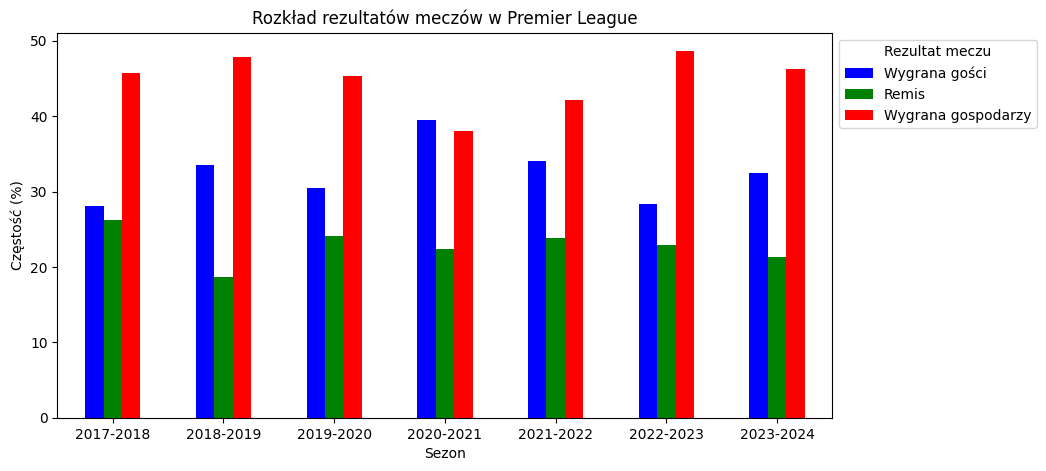

            away win       draw   home win
season                                    
2017-2018  28.108108  26.216216  45.675676
2018-2019  33.513514  18.648649  47.837838
2019-2020  30.540541  24.054054  45.405405
2020-2021  39.459459  22.432432  38.108108
2021-2022  34.054054  23.783784  42.162162
2022-2023  28.378378  22.972973  48.648649
2023-2024  32.432432  21.351351  46.216216
average    32.355212  22.779923  44.864865


In [24]:
plot_match_outcomes(df, 'Rozkład rezultatów meczów w Premier League')

In [27]:
def goals_num(total_goals):
    if total_goals <= 2:
        return '0-2'
    elif total_goals <= 4:
        return '3-4'
    else:
        return '5+'

def plot_total_goals(df, title_name, unstack=True):
    season_goals_num = df.groupby('season').apply(
    lambda x: x['total_goals'].apply(goals_num).value_counts(normalize=True) * 100
    )
    if unstack:
        season_goals_num=season_goals_num.unstack()

    colors=["#9496fa", "#6568f9", "#3337fb"]
    season_goals_num.plot(kind='bar', figsize=(10, 5), color=colors)
    plt.title(title_name)
    plt.xlabel('Sezon')
    plt.xticks(rotation=0)
    plt.ylabel('Częstość (%)')
    plt.legend(title='Liczba bramek', bbox_to_anchor=(1, 1))
    plt.show()

    mean_all = season_goals_num.mean()
    season_goals_num.loc['average'] = mean_all
    print(season_goals_num)


C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\3955825795.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_goals_num = df.groupby('season').apply(


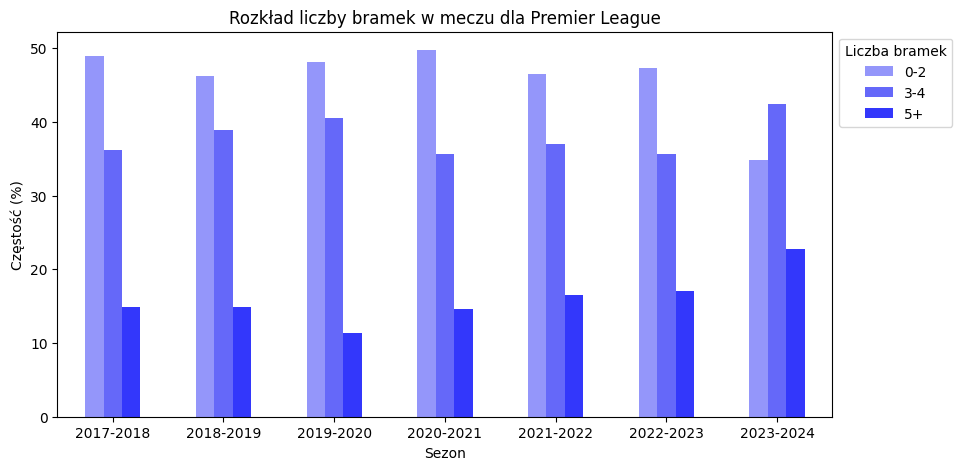

total_goals        0-2        3-4         5+
season                                      
2017-2018    48.918919  36.216216  14.864865
2018-2019    46.216216  38.918919  14.864865
2019-2020    48.108108  40.540541  11.351351
2020-2021    49.729730  35.675676  14.594595
2021-2022    46.486486  37.027027  16.486486
2022-2023    47.297297  35.675676  17.027027
2023-2024    34.864865  42.432432  22.702703
average      45.945946  38.069498  15.984556


In [29]:
plot_total_goals(df, "Rozkład liczby bramek w meczu dla Premier League")

C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\3955825795.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_goals_num = df.groupby('season').apply(


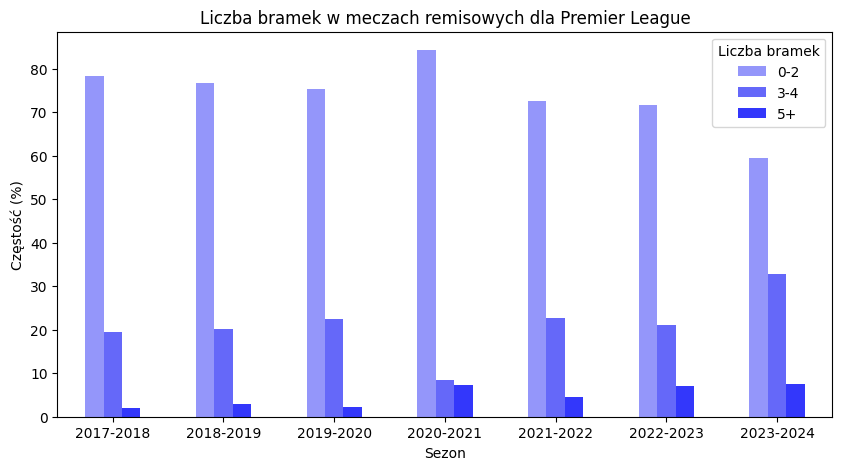

total_goals        0-2        3-4        5+
season                                     
2017-2018    78.350515  19.587629  2.061856
2018-2019    76.811594  20.289855  2.898551
2019-2020    75.280899  22.471910  2.247191
2020-2021    84.337349   8.433735  7.228916
2021-2022    72.727273  22.727273  4.545455
2022-2023    71.764706  21.176471  7.058824
2023-2024    59.493671  32.911392  7.594937
average      74.109430  21.085466  4.805104


In [31]:
df_draws=df[df['outcome']==0.5]
plot_total_goals(df_draws, "Rozkład liczby bramek w meczach remisowych dla Premier League", unstack=False)

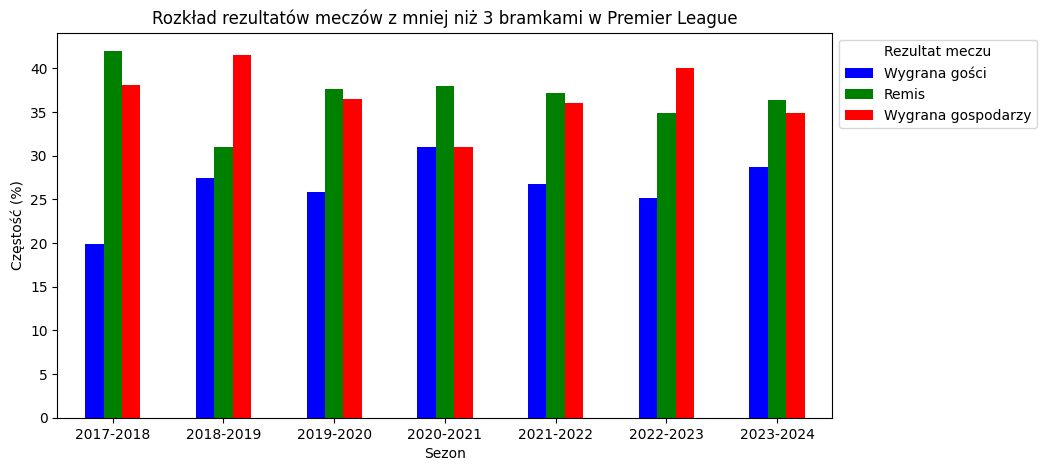

            away win       draw   home win
season                                    
2017-2018  19.889503  41.988950  38.121547
2018-2019  27.485380  30.994152  41.520468
2019-2020  25.842697  37.640449  36.516854
2020-2021  30.978261  38.043478  30.978261
2021-2022  26.744186  37.209302  36.046512
2022-2023  25.142857  34.857143  40.000000
2023-2024  28.682171  36.434109  34.883721
average    26.395008  36.738226  36.866766


In [32]:
df_total_goals_less_eq_2=df[df['total_goals']<=2]
plot_match_outcomes(df_total_goals_less_eq_2, 'Rozkład rezultatów meczów z mniej niż 3 bramkami w Premier League')


In [33]:
print(f"Średnia liczba bramek w meczu {np.mean(df['total_goals'])}")

Średnia liczba bramek w meczu 2.8378378378378377


### Rozkład Poissona

Zakładamy, że liczba strzelanych w meczu bramek przez drużynę ma rozkład Poissona. Oczywiście drużyna ma większe szanse na strzelenie goli gdy gra ze słabszą drużyną, w szczególności taką która ma słabą obronę. Należy więc uwzględnić siłę ataku danej drużyny i siłę obrony przeciwnika. Robimy to znajdując odpowiednią formułę na paramater lambda.

#### Obliczanie średniej liczby goli w ostatnich meczach dla całej ligi

W tym modelu będziemy chcieli osobno przeanalizować mecze wyjazdowe i domowe, dlatego stworzymy pomocniczą funkcję zliczającą statystyki z ostatnich meczów w podziale na mecze domowe i wyjazdowe.

In [37]:
def calculate_rolling_avg(period, column, new_column, home_away, df):
    df.sort_values(by=["season", home_away, "datetime"], inplace=True)
    df[new_column]=df.groupby(home_away)[column].transform(
        lambda x: x.shift(1).rolling(window=period, min_periods=0).mean()
    )   
    df[new_column].fillna(0.2, inplace=True)
    return df

In [39]:
df["home_goals_conceded"]=df["away_goals"]
df["away_goals_conceded"]=df["home_goals"]

In [40]:
columns_to_calculate = {
    "home_goals": "home_team",
    "home_goals_conceded": "home_team",
    "away_goals": "away_team",
    "away_goals_conceded": "away_team",
}

rolling_periods = [5, 10, 20]
for period in rolling_periods:
    for column, team_type in columns_to_calculate.items():
        new_column_name = f"{column}_last{period}"
        df = calculate_rolling_avg(period, column, new_column_name, team_type, df)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1616956228.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[new_column].fillna(0.2, inplace=True)
C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1616956228.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [53]:
df_avg_league_home = df.groupby(["season", "round"]).agg(
    home_scored_avg_league_last5=("home_goals_last5", "mean"),
    home_scored_avg_league_last10=("home_goals_last10", "mean"),
    home_scored_avg_league_last20=("home_goals_last20", "mean"),
    home_conceded_avg_league_last5=("home_goals_conceded_last5", "mean"),
    home_conceded_avg_league_last10=("home_goals_conceded_last10", "mean"),
    home_conceded_avg_league_last20=("home_goals_conceded_last20", "mean"),
).reset_index()

df_avg_league_away= df.groupby(["season", "round"]).agg(
    away_scored_avg_league_last5=("away_goals_last5", "mean"),
    away_scored_avg_league_last10=("away_goals_last10", "mean"),
    away_scored_avg_league_last20=("away_goals_last20", "mean"),
    away_conceded_avg_league_last5=("away_goals_conceded_last5", "mean"),
    away_conceded_avg_league_last10=("away_goals_conceded_last10", "mean"),
    away_conceded_avg_league_last20=("away_goals_conceded_last20", "mean"),
).reset_index()

In [54]:
foot_df=df.merge(df_avg_league_home, on=["season", "round"], how='left')
foot_df=foot_df.merge(df_avg_league_away, on=["season", "round"], how='left')
foot_df.tail()

,Unnamed: 0,season,datetime,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,League,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch wi

In [55]:
foot_df.drop(columns=["Unnamed: 0"], inplace=True)

Pomocnicza funkcja do tworzenia przewidywanych bramek na podstawie rozkładu Poissona

In [56]:
def calculate_poisson_goals(df, epsilon=1e-9, a=6/10, b=3/10, c=1/10, col_name="poisson_goals"):
    
    #Współczynniki ofensywne i defensywne dla gospodarzy
    df["offensive_power_home"] = (
        a * (df['home_goals_last5'] / (df['home_scored_avg_league_last5'] + epsilon)) +
        b * (df['home_goals_last10'] / (df['home_scored_avg_league_last10'] + epsilon)) +
        c * (df['home_goals_last20'] / (df['home_scored_avg_league_last20'] + epsilon))
    )
    df["defensive_power_home"] = (
        a * (df['home_goals_conceded_last5'] / (df['home_conceded_avg_league_last5'] + epsilon)) +
        b * (df['home_goals_conceded_last10'] / (df['home_conceded_avg_league_last10'] + epsilon)) +
        c * (df['home_goals_conceded_last20'] / (df['home_conceded_avg_league_last20'] + epsilon))
    )
    
    #Współczynniki ofensywne i defensywne dla gości
    df["offensive_power_away"] = (
        a * (df['away_goals_last5'] / (df['away_scored_avg_league_last5'] + epsilon)) +
        b * (df['away_goals_last10'] / (df['away_scored_avg_league_last10'] + epsilon)) +
        c * (df['away_goals_last20'] / (df['away_scored_avg_league_last20'] + epsilon))
    )
    df["defensive_power_away"] = (
        a * (df['away_goals_conceded_last5'] / (df['away_conceded_avg_league_last5'] + epsilon)) +
        b * (df['away_goals_conceded_last10'] / (df['away_conceded_avg_league_last10'] + epsilon)) +
        c * (df['away_goals_conceded_last20'] / (df['away_conceded_avg_league_last20'] + epsilon))
    )
    
    #Przewidywana liczba goli dla gospodarzy
    df[f"{col_name}_home"] = (
        df["offensive_power_home"] * df["defensive_power_away"] *
        (a * df["home_scored_avg_league_last5"] +
         b * df["home_scored_avg_league_last10"] +
         c * df["home_scored_avg_league_last20"])
    )
    
    #Przewidywana liczba goli dla gości
    df[f"{col_name}_away"] = (
        df["offensive_power_away"] * df["defensive_power_home"] *
        (a * df["away_scored_avg_league_last5"] +
         b * df["away_scored_avg_league_last10"] +
         c * df["away_scored_avg_league_last20"])
    )
    
    return df

In [57]:
foot_df = calculate_poisson_goals(foot_df, epsilon=1e-9, a=1, b=0, c=0, col_name="last5_poisson_goals")

In [58]:
foot_df.tail()

,season,datetime,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,League,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch width m,latit

Możemy też spróbować znaleźć współczynniki za pomocą regresji Poissona

In [ ]:
X_home=foot_df[["offensive_power_home", "defensive_power_away", "home_goals_last5"]]
y_home=foot_df["home_goals"]

model_home = statsmodels.discrete.discrete_model.Poisson(y_home, X_home)
model_home = model_home.fit()
print(model_home.summary())

lambda_home_pred=model_home.predict(X_home)
foot_df["poisson_regr_lambda_home"]=lambda_home_pred

X_away=foot_df[["offensive_power_away", "defensive_power_home", "away_goals_last5"]]
y_away=foot_df["away_goals"]

model_away = statsmodels.discrete.discrete_model.Poisson(y_away, X_away)
model_away = model_away.fit()
print(model_away.summary())

lambda_away_pred=model_away.predict(X_away)
foot_df["poisson_regr_lambda_away"]=lambda_away_pred

Optimization terminated successfully.
         Current function value: 1.567951
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:             home_goals   No. Observations:                 2590
Model:                        Poisson   Df Residuals:                     2587
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Jan 2025   Pseudo R-squ.:                 0.02164
Time:                        15:02:02   Log-Likelihood:                -4061.0
converged:                       True   LL-Null:                       -4150.8
Covariance Type:            nonrobust   LLR p-value:                 9.856e-40
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
offensive_power_home    -0.0082      0.088     -0.094      0.925      -0.180       0.163

#### Pomocnicze funkcje do przewidywania wyników

In [61]:
def calculate_pred_result_matrix(row, poiss_goals_home, poiss_goals_away):
    home_goals=np.array([poisson.pmf(i, row[poiss_goals_home]) for i in range(8)])
    away_goals=np.array([poisson.pmf(i, row[poiss_goals_away]) for i in range(8)])
    x_grid, y_grid=np.meshgrid(home_goals, away_goals, indexing='ij')
    pred_results_matrix=(x_grid*100).T*y_grid.T
    return pred_results_matrix

In [62]:
def calculate_probabilities_of_win(row, poiss_goals_home, poiss_goals_away):
    pred_results_matrix=calculate_pred_result_matrix(row, poiss_goals_home, poiss_goals_away)
    prob_win_home=np.triu(pred_results_matrix).sum()-np.trace(pred_results_matrix)
    prob_win_away=np.tril(pred_results_matrix).sum()-np.trace(pred_results_matrix)
    prob_draw=100-prob_win_home-prob_win_away
    return prob_win_home, prob_draw, prob_win_away

In [64]:
def get_probabilities(df, poiss_goals_home, poiss_goals_away):
    s=0
    probabilities=[]
    for i in range(df.shape[0]):
        probs=calculate_probabilities_of_win(df.iloc[i], poiss_goals_home, poiss_goals_away)
        probabilities.append(probs)
    return probabilities

In [66]:
def calculate_probabilities_of_goals_above(row, goals, poiss_goals_home, poiss_goals_away):
    pred_results_matrix=calculate_pred_result_matrix(row, poiss_goals_home, poiss_goals_away)
    small_matrix=pred_results_matrix[:goals+1, :goals+1]
    small_matrix=np.rot90(small_matrix, k=-1)
    prob=100-np.triu(small_matrix).sum()
    return prob

In [67]:
def check_model_acc(df, poiss_goals_home, poiss_goals_away):
    s=0
    for i in range(df.shape[0]):
        probs=calculate_probabilities_of_win(df.iloc[i], poiss_goals_home, poiss_goals_away)
        p=np.argmax(probs)
        if ((df.iloc[i]['outcome']==1) & (p==0)) | ((df.iloc[i]['outcome']==0.5) & (p==1)) | ((df.iloc[i]['outcome']==0) & (p==2)):
            s+=1
    return s/df.shape[0]

In [68]:
foot_df[['home_goals', 'away_goals', 'outcome']].tail()

,home_goals,away_goals,outcome
2585,2,0,1.0
2586,1,1,0.5
2587,2,2,0.5
2588,5,1,1.0
2589,2,0,1.0


In [82]:
foot_df.sort_values(["season", "datetime"], inplace=True)

Pierwsze kolejki mają ustalone losowe parametry

In [223]:
foot_df_test=foot_df[200:]

In [98]:
check_model_acc(foot_df_test, poiss_goals_home="last5_best_found_poisson_goals_home", poiss_goals_away="last5_best_found_poisson_goals_away")

0.4870292887029289

In [99]:
check_model_acc(foot_df_test, poiss_goals_home="poisson_regr_lambda_home", poiss_goals_away="poisson_regr_lambda_away")

0.49581589958158995

In [100]:
foot_df = calculate_poisson_goals(foot_df, epsilon=1e-9, a=0.6, b=0.3, c=0.1, col_name="best_found_poisson_goals")

In [101]:
check_model_acc(foot_df_test, poiss_goals_home="best_found_poisson_goals_home", poiss_goals_away="best_found_poisson_goals_away")

0.501673640167364

Najgorzej model radzi sobie z przewidywaniem remisów, dlatego sprawdźmy jak wygląda predykcja dla meczów bez remisów.

In [118]:
foot_df_test_without_draws=foot_df_test[foot_df_test["outcome"]!=0.5]

In [120]:
check_model_acc(foot_df_test_without_draws, poiss_goals_home="best_found_poisson_goals_home", poiss_goals_away="best_found_poisson_goals_away")

0.6377358490566037

#### Wykres kalibracji modelu

In [232]:
home_win_probs=np.array(get_probabilities(foot_df_test, poiss_goals_home="best_found_poisson_goals_home", poiss_goals_away="best_found_poisson_goals_away"))[:, 0]
draw_probs=np.array(get_probabilities(foot_df_test, poiss_goals_home="best_found_poisson_goals_home", poiss_goals_away="best_found_poisson_goals_away"))[:, 1]
away_win_probs=np.array(get_probabilities(foot_df_test, poiss_goals_home="best_found_poisson_goals_home", poiss_goals_away="best_found_poisson_goals_away"))[:, 2]

In [230]:
def calibration_plot(y, home_win_probs, away_win_probs, draw_probs, title="Wykres kalibracji modelu"):
    df = pd.DataFrame({
        'home_win_prob': home_win_probs,
        'away_win_prob': away_win_probs,
        'draw_prob': draw_probs,
        'actual': [int(x*2) for x in y]
    })

    bins = np.linspace(0, 1, 11)
    df['bin_home_win'] = pd.cut(df['home_win_prob'], bins=bins, labels=bins[:-1])
    df['bin_draw'] = pd.cut(df['draw_prob'], bins=bins, labels=bins[:-1])
    df['bin_away_win'] = pd.cut(df['away_win_prob'], bins=bins, labels=bins[:-1])
    print(bins)
    calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
        lambda x: pd.Series({
            'avg_pred_prob': x['home_win_prob'].mean(),
            'observed_freq': (x['actual'] == 2).mean(),
            'count': x['home_win_prob'].count(),
            'difference' : - x['home_win_prob'].mean() + (x['actual'] == 2).mean()
        })
    ).reset_index()
    calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
        lambda x: pd.Series({
            'avg_pred_prob': x['draw_prob'].mean(),
            'observed_freq': (x['actual'] == 1).mean(),
            'count': x['home_win_prob'].count(),
            'difference': - x['draw_prob'].mean() + (x['actual'] == 1).mean()
        })
    ).reset_index()
    calibration_away_win = df.groupby('bin_away_win', observed=False, dropna=False).apply(
        lambda x: pd.Series({
            'avg_pred_prob': x['away_win_prob'].mean(),
            'observed_freq': (x['actual'] == 0).mean(),
            'count': x['home_win_prob'].count(),
            'difference': - x['away_win_prob'].mean() + (x['actual'] == 0).mean()
        })
    ).reset_index()

    def mask_low_count(df, bin_col):
        for col in df.columns:
            if col != bin_col and col != 'count':
                df.loc[df['count'] < 10, col] = None
        return df

    calibration_home_win = mask_low_count(calibration_home_win, 'bin_home_win')
    calibration_draw = mask_low_count(calibration_draw, 'bin_draw')
    calibration_away_win = mask_low_count(calibration_away_win, 'bin_away_win')

    plt.figure(figsize=(8, 6))
    plt.plot(calibration_home_win['avg_pred_prob'], calibration_home_win['observed_freq'], marker='o', label="Częstość zwycięstw gospodarzy")
    plt.plot(calibration_draw['avg_pred_prob'], calibration_draw['observed_freq'], marker='o', label="Częstość remisów")
    plt.plot(calibration_away_win['avg_pred_prob'], calibration_away_win['observed_freq'], marker='o', label="Częstość zwycięstw gości")
    plt.plot([0, 1], [0, 1], 'k--', label="Idealna Kalibracja")
    plt.title(title)
    plt.xlabel("Przewidywane prawdopodobieństwo")
    plt.ylabel("Zaobserwowana częstość")
    plt.legend()
    plt.grid()
    plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
C:\Users\Kuba\AppD

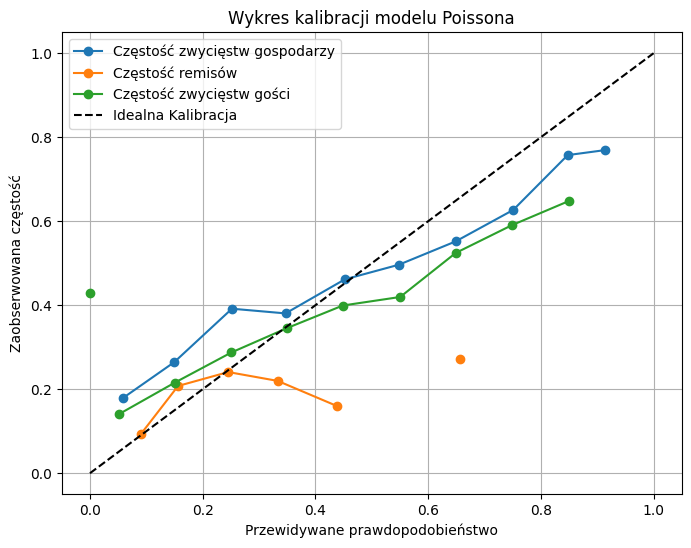

In [233]:
calibration_plot(foot_df_test['outcome'], home_win_probs*0.01, away_win_probs*0.01, draw_probs*0.01, title="Wykres kalibracji modelu Poissona")

In [125]:
(foot_df_test["outcome"]==0.5).sum()

np.int64(535)

#### Przewidywanie łącznej liczby bramek w meczu

In [126]:
def check_model_acc_above_goals(df, goals, poiss_goals_home, poiss_goals_away):
    s=0
    for i in range(df.shape[0]):
        prob=calculate_probabilities_of_goals_above(df.iloc[i], goals, poiss_goals_home, poiss_goals_away)
        if ((prob>=50) & (df.iloc[i]['total_goals']>goals)) | ((prob<=50) & (df.iloc[i]['total_goals']<=goals)):
            s+=1
    return s/df.shape[0]

In [128]:
check_model_acc_above_goals(foot_df_test, 2, poiss_goals_home="best_found_poisson_goals_home", poiss_goals_away="best_found_poisson_goals_away")

0.5242677824267783

Obliczenie lambdy Poissona na podstawie expected goals

In [129]:
def calc_acc(model_col):
    acc=(
        ((foot_df['total_goals'] > 2) & (model_col > 0.5)).sum() + 
        ((foot_df['total_goals'] <= 2) & (model_col <= 0.5)).sum()
    ) / foot_df.shape[0]
    return acc

In [132]:
lambda1_xg=foot_df['home_last5_xg']
lambda2_xg=foot_df['away_last5_xg']
lambda_total_xg=lambda1_xg+lambda2_xg
calc_acc(1-poisson.cdf(1, lambda_total_xg))

np.float64(0.5436293436293437)

#### Uporządkowany model probitowy

Prosty przykład

In [133]:
X= foot_df[[
    'home_last5_xg', 
    'away_last5_xg', 
]]

y=foot_df['outcome']

In [136]:
mod_prob = OrderedModel(y,X,distr='probit')

res_prob = mod_prob.fit(method='bfgs')

num_of_thresholds = 2
mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])

Optimization terminated successfully.
         Current function value: 1.006174
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15


array([       -inf, -0.51022353,  0.12226128,         inf])

In [137]:
res_prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                outcome   Log-Likelihood:                -2606.0
Model:                   OrderedModel   AIC:                             5220.
Method:            Maximum Likelihood   BIC:                             5243.
Date:                Thu, 09 Jan 2025                                         
Time:                        16:54:35                                         
No. Observations:                2590                                         
Df Residuals:                    2586                                         
Df Model:                           2                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
home_last5_xg     0.5765      0.048     11.955      0.000       0.482       0.671
away_last5_xg    -0.5760      0.046    -12.437      0.000      -0.667      -0.485
0.0/0.5          -0.5102      0.092     -5.554      0.000      -0.690      -0.330
0.5/1.0          -0.4581      0.037    -12.355      0.000      -0.531      -0.385
=================================================================================
"""

Współczynniki są zgodne z intuicją. Więcej spodziewanych bramek gospodarza zwiększa jego szansę na wygraną, a większa liczba spodziewanych bramek dla gościa zmniejsza szanse na wygranie gospodarza.

In [138]:
predicted = res_prob.model.predict(res_prob.params, exog=X)
max_ind = np.argmax(predicted, axis=1)
max_val = np.max(predicted, axis=1)

pred_choice = []
for i, max_value in enumerate(max_val):
    pred_choice.append(max_ind[i]/2)
(pred_choice == y).sum()/len(pred_choice)

np.float64(0.5073359073359074)

#### Selekcja zmiennych

In [145]:
numeric_columns = foot_df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns[(numeric_columns.str.endswith('last5')) | (numeric_columns.str[5:10] == 'last5')]
X_numeric = foot_df[numeric_columns]
y = foot_df['outcome']

Korelacja ze zmienną zależną

In [146]:
corr_matrix = X_numeric.corrwith(y).abs().sort_values(ascending=False)

top_50_features = corr_matrix.head(50)
print(top_50_features)

home_last5_passes_completed                0.248568
home_last5_passes_received                 0.248520
home_last5_passes_live                     0.247033
home_last5_passes_total_distance           0.246873
home_last5_passes                          0.246620
home_last5_carries                         0.245022
away_last5_touches_att_pen_area            0.244571
home_last5_touches                         0.241686
home_last5_touches_live_ball               0.241656
home_last5_touches_att_3rd                 0.240767
home_last5_pass_xa                         0.239548
away_last5_passes_completed                0.239433
away_last5_passes_received                 0.239273
home_last5_passes_short                    0.238611
home_last5_passes_completed_short          0.238144
away_last5_carries_progressive_distance    0.238003
home_last5_progressive_passes              0.237995
home_last5_carries_distance                0.237946
home_last5_progressive_passes_received     0.237945
away_last5_p

ANOVA

In [151]:
f_values, p_values = f_classif(X_numeric, y)
anova_results = pd.DataFrame({'feature': X_numeric.columns, 'f_value': f_values, 'p_value': p_values})
top_50_anova_features = anova_results[anova_results['p_value'] < 0.05].sort_values(by='f_value', ascending=False).head(50)
print(top_50_anova_features)

                                     feature    f_value       p_value
24               home_last5_passes_completed  92.303110  1.900859e-39
89                home_last5_passes_received  92.177847  2.136632e-39
48                    home_last5_passes_live  91.216375  5.243850e-39
25                         home_last5_passes  90.929578  6.855067e-39
32          home_last5_passes_total_distance  90.674293  8.701782e-39
28                        home_last5_carries  90.475940  1.047404e-38
15                        home_last5_touches  87.509998  1.679930e-37
79              home_last5_touches_live_ball  87.494971  1.703740e-37
35                   home_last5_passes_short  84.561808  2.665766e-36
181          away_last5_touches_att_pen_area  84.508707  2.802002e-36
83               home_last5_carries_distance  84.475895  2.889648e-36
34         home_last5_passes_completed_short  84.258448  3.544040e-36
77                home_last5_touches_att_3rd  84.092995  4.139652e-36
37        home_last5

Według Anovy prawie wszystkie zmienne różnicują wynik meczu

In [152]:
y_goals_bin = (foot_df['total_goals']>2).astype(int)

In [153]:
f_values, p_values = f_classif(X_numeric, y_goals_bin)
anova_results = pd.DataFrame({'feature': X_numeric.columns, 'f_value': f_values, 'p_value': p_values})
top_50_anova_features = anova_results[anova_results['p_value'] < 0.05].sort_values(by='f_value', ascending=False).head(50)
print(top_50_anova_features)

                                     feature    f_value       p_value
78           home_last5_touches_att_pen_area  28.882734  8.375607e-08
86      home_last5_carries_into_penalty_area  25.721524  4.223084e-07
46       home_last5_passes_into_penalty_area  23.484125  1.333897e-06
28                        home_last5_carries  22.531196  2.180166e-06
43                        home_last5_pass_xa  22.471093  2.248850e-06
20                           home_last5_npxg  22.123554  2.690836e-06
83               home_last5_carries_distance  21.927867  2.977074e-06
21                      home_last5_xg_assist  21.461678  3.788372e-06
19                             home_last5_xg  21.307249  4.103422e-06
147                away_last5_assisted_shots  21.282846  4.155559e-06
114                         away_last5_shots  20.201335  7.276960e-06
125                           away_last5_sca  20.157902  7.442767e-06
84   home_last5_carries_progressive_distance  20.003582  8.063198e-06
27             home_

#### Random forest - feature importance i przewidywanie wyników

In [155]:
y = foot_df['outcome'].astype('str') 

rf = RandomForestClassifier(n_estimators=100, random_state=123)

rf.fit(X_numeric, y)

feature_importance = pd.Series(rf.feature_importances_, index=X_numeric.columns).sort_values(ascending=False)
print(feature_importance)

home_last5_passes_received                 0.008157
away_last5_progressive_carries             0.007759
home_last5_passes_total_distance           0.007381
home_last5_touches_att_3rd                 0.007305
home_last5_pass_xa                         0.007060
home_last5_passes_progressive_distance     0.007040
home_last5_passes_live                     0.006969
away_last5_sca                             0.006960
home_last5_touches_mid_3rd                 0.006823
home_last5_progressive_passes_received     0.006713
home_last5_touches_live_ball               0.006706
away_last5_ball_recoveries                 0.006673
away_last5_xg                              0.006670
home_last5_carries                         0.006494
home_last5_aerials_lost                    0.006477
away_last5_aerials_lost                    0.006439
away_last5_touches_att_3rd                 0.006434
away_last5_carries_progressive_distance    0.006421
home_last5_sca                             0.006387
away_last5_t

In [215]:
features = ['home_last5_goals', 'away_last5_goals', 'home_last5_touches_att_3rd', 'away_last5_touches_att_3rd', 'home_last5_passes_completed', 'away_last5_passes_completed', 'home_last5_pass_xa', 'away_last5_pass_xa', 'home_last5_passes_progressive_distance']
X = foot_df[features] 
y = (foot_df['outcome']).astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

rf = RandomForestClassifier(n_estimators=150, random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

y_pred_probabilities = rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5070785070785071


<Axes: >

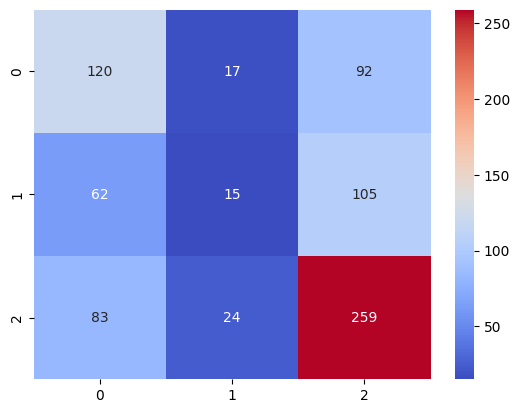

In [216]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')

In [217]:
y_pred_probabilities

array([[0.20666667, 0.20666667, 0.58666667],
       [0.86      , 0.12      , 0.02      ],
       [0.20666667, 0.18666667, 0.60666667],
       ...,
       [0.32      , 0.28      , 0.4       ],
       [0.20666667, 0.28      , 0.51333333],
       [0.04666667, 0.04666667, 0.90666667]])

In [244]:
home_win_probs=y_pred_probabilities[:, 2]
draw_probs=y_pred_probabilities[:, 1]
away_win_probs=y_pred_probabilities[:, 0]

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
C:\Users\Kuba\AppD

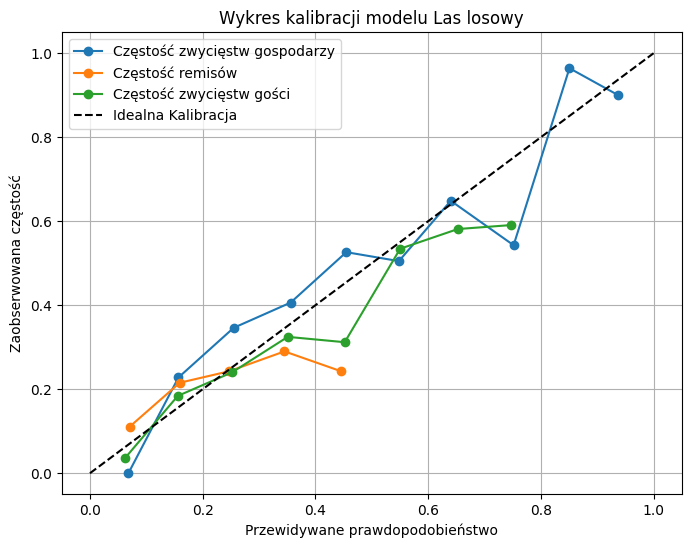

In [245]:
calibration_plot(pd.to_numeric(y_test), home_win_probs, away_win_probs, draw_probs, title="Wykres kalibracji modelu Las losowy")

Uporządkowany model probitowy na podstawie zmiennych z feature importances

In [312]:
features = ['home_last5_goals', 'away_last5_goals', 'home_last5_touches_att_3rd', 'away_last5_touches_att_3rd', 'home_last5_passes_completed', 'away_last5_passes_completed', 'home_last5_pass_xa', 'away_last5_pass_xa']
earlier_seasons=['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']
last_seasons=['2023-2024']
X_train=foot_df[foot_df['season'].isin(earlier_seasons)][features]
y_train=foot_df[foot_df['season'].isin(earlier_seasons)]['outcome']

X_test=foot_df[foot_df['season'].isin(last_seasons)][features]
y_test=foot_df[foot_df['season'].isin(last_seasons)]['outcome']

In [313]:
ordered_logit_model = OrderedModel(y_test, X_test, distr='logit')

ordered_logit_model_results=ordered_logit_model.fit(method='bfgs')

num_of_thresholds = 2
ordered_logit_model.transform_threshold_params(res_prob.params[-num_of_thresholds:])

Optimization terminated successfully.
         Current function value: 0.937291
         Iterations: 42
         Function evaluations: 51
         Gradient evaluations: 51


array([       -inf, -0.63074216,  0.43860637,         inf])

In [314]:
predictions = ordered_logit_model_results.model.predict(ordered_logit_model_results.params, exog=X_test)
max_ind = np.argmax(predictions, axis=1)
max_val = np.max(predictions, axis=1)

pred_choice = []
for i, max_value in enumerate(max_val):
    pred_choice.append(max_ind[i]/2)
(pred_choice == y_test).sum()/len(pred_choice)

np.float64(0.5594594594594594)

In [315]:
predictions

array([[0.3042702 , 0.25601098, 0.43971882],
       [0.33899862, 0.26007067, 0.40093071],
       [0.30523067, 0.25616701, 0.43860231],
       ...,
       [0.55084906, 0.23048376, 0.21866718],
       [0.06286064, 0.10061888, 0.83652048],
       [0.07644539, 0.11785513, 0.80569947]])

In [316]:
ordered_logit_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                outcome   Log-Likelihood:                -346.80
Model:                   OrderedModel   AIC:                             713.6
Method:            Maximum Likelihood   BIC:                             752.7
Date:                Thu, 09 Jan 2025                                         
Time:                        20:34:46                                         
No. Observations:                 370                                         
Df Residuals:                     360                                         
Df Model:                           8                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
home_last5_goals                0.5287      0.188      2.812      0.005       0.160       0.897
away_last5_goals               -0.1787      0.173     -1.036      0.300      -0.517       0.160
home_last5_touches_att_3rd      0.0086      0.005      1.880      0.060      -0.000       0.018
away_last5_touches_att_3rd     -0.0075      0.005     -1.650      0.099      -0.016       0.001
home_last5_passes_completed     0.0006      0.002      0.361      0.718      -0.002       0.004
away_last5_passes_completed    -0.0011      0.002     -0.723      0.469      -0.004       0.002
home_last5_pass_xa              0.2063      0.501      0.412      0.680      -0.775       1.188
away_last5_pass_xa             -0.3861      0.479     -0.805      0.421      -1.326       0.554
0.0/0.5                        -0.6307      0.530     -1.190      0.234      -1.669       0.408
0.5/1.0                         0.0670      0.103      0.648      0.517      -0.136       0.270
===============================================================================================
"""

In [317]:
home_win_probs=predictions[:, 2]
draw_probs=predictions[:, 1]
away_win_probs=predictions[:, 0]

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
C:\Users\Kuba\AppD

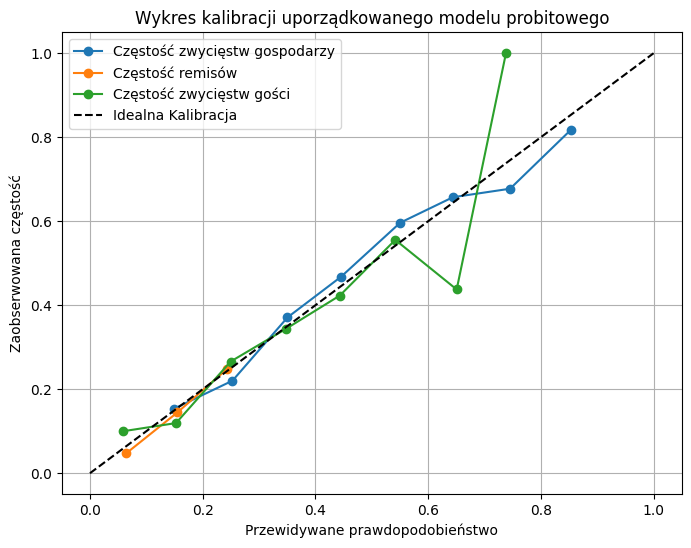

In [318]:
calibration_plot(pd.to_numeric(y_test), home_win_probs, away_win_probs, draw_probs, title="Wykres kalibracji uporządkowanego modelu probitowego")

Jako, że mamy bardzo dużo zmiennych ograniczymy nasz zbiór do klasycznych statystyk z meczów.

In [206]:
selected_features=["home_last5_goals", "away_last5_goals", "home_last5_assists", "away_last5_assists", "home_last5_shots", "away_last5_shots", "home_last5_passes", "away_last5_passes", "home_last5_tackles", "away_last5_tackles"]
X = foot_df[selected_features] 
y = (foot_df['outcome']).astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

rf = RandomForestClassifier(n_estimators=150, random_state=1)

rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

home_last5_passes     0.139994
away_last5_passes     0.138212
home_last5_shots      0.113299
away_last5_shots      0.111183
away_last5_tackles    0.109937
home_last5_tackles    0.105459
away_last5_goals      0.074550
home_last5_goals      0.073628
home_last5_assists    0.067165
away_last5_assists    0.066573
dtype: float64
0.5083655083655083


#### Metryki pogodowe

In [175]:
foot_df.head()

,season,datetime,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,League,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch width m,latit

In [176]:
foot_df[['weather_temperature', 'weather_precipitation', 'weather_wind', 'weather_humidity', 'weather_cloud_cover']].mean()

weather_temperature      10.833320
weather_precipitation     0.122201
weather_wind             16.998108
weather_humidity         75.292664
weather_cloud_cover      74.688031
dtype: float64

In [177]:
foot_df_without_rain=foot_df[foot_df["weather_precipitation"]==0]
foot_df_with_rain=foot_df[foot_df["weather_precipitation"]>0]

In [178]:
foot_df_without_rain.shape[0]

1935

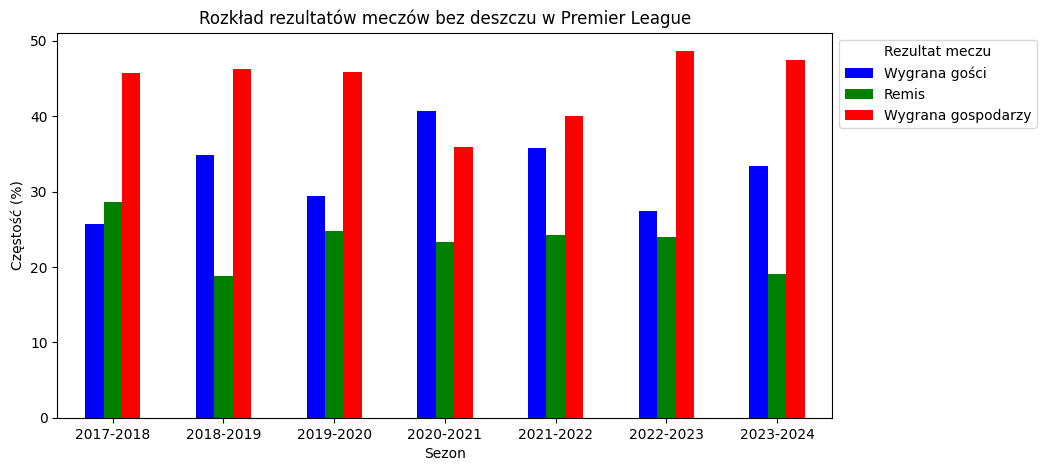

            away win       draw   home win
season                                    
2017-2018  25.650558  28.624535  45.724907
2018-2019  34.875445  18.861210  46.263345
2019-2020  29.390681  24.731183  45.878136
2020-2021  40.711462  23.320158  35.968379
2021-2022  35.789474  24.210526  40.000000
2022-2023  27.364865  23.986486  48.648649
2023-2024  33.455882  19.117647  47.426471
average    32.462624  23.264535  44.272841


In [179]:
plot_match_outcomes(foot_df_without_rain, 'Rozkład rezultatów meczów bez deszczu w Premier League')

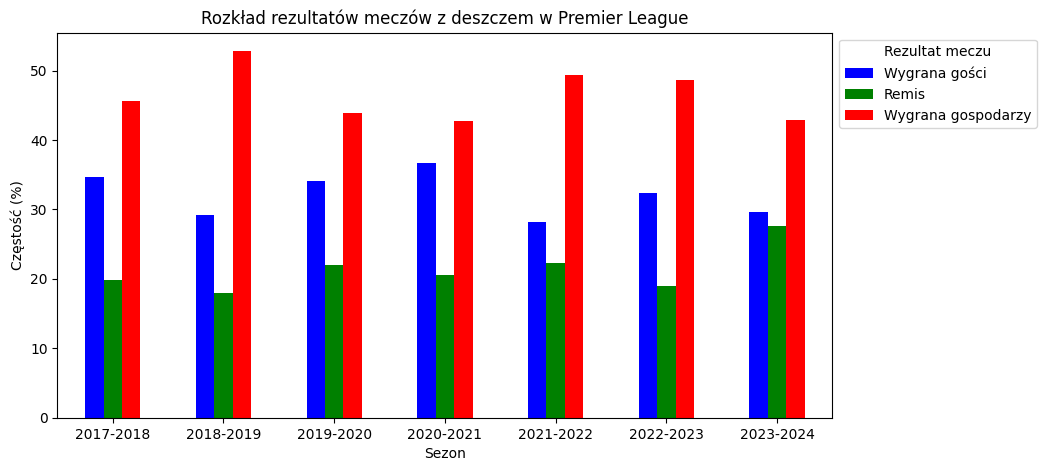

            away win       draw   home win
season                                    
2017-2018  34.653465  19.801980  45.544554
2018-2019  29.213483  17.977528  52.808989
2019-2020  34.065934  21.978022  43.956044
2020-2021  36.752137  20.512821  42.735043
2021-2022  28.235294  22.352941  49.411765
2022-2023  32.432432  18.918919  48.648649
2023-2024  29.591837  27.551020  42.857143
average    32.134940  21.299033  46.566027


In [180]:
plot_match_outcomes(foot_df_with_rain, 'Rozkład rezultatów meczów z deszczem w Premier League')

In [181]:
print(f"Średnia liczba bramek w meczach z deszczem {np.mean(foot_df_without_rain['total_goals'])}")

Średnia liczba bramek w meczach z deszczem 2.8237726098191214


In [182]:
print(f"Średnia liczba bramek w meczach bez deszczu  {np.mean(foot_df_with_rain['total_goals'])}")

Średnia liczba bramek w meczach bez deszczu  2.879389312977099


C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\3955825795.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_goals_num = df.groupby('season').apply(


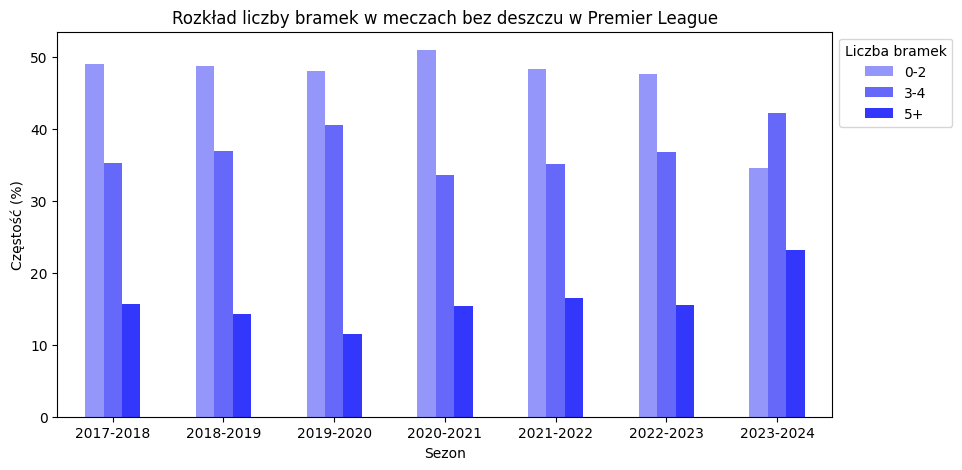

total_goals        0-2        3-4         5+
season                                      
2017-2018    49.070632  35.315985  15.613383
2018-2019    48.754448  37.010676  14.234875
2019-2020    48.028674  40.501792  11.469534
2020-2021    50.988142  33.596838  15.415020
2021-2022    48.421053  35.087719  16.491228
2022-2023    47.635135  36.824324  15.540541
2023-2024    34.558824  42.279412  23.161765
average      46.779558  37.230964  15.989478


In [184]:
plot_total_goals(foot_df_without_rain, "Rozkład liczby bramek w meczach bez deszczu w Premier League")

Zdefiniowanie dobrej i złej pogody

In [185]:
good_weather_ids=(foot_df['weather_temperature']>10) & (foot_df['weather_precipitation']<0.2) & (foot_df['weather_wind']<30)

In [186]:
foot_df[good_weather_ids].shape[0]/foot_df.shape[0]

0.4135135135135135

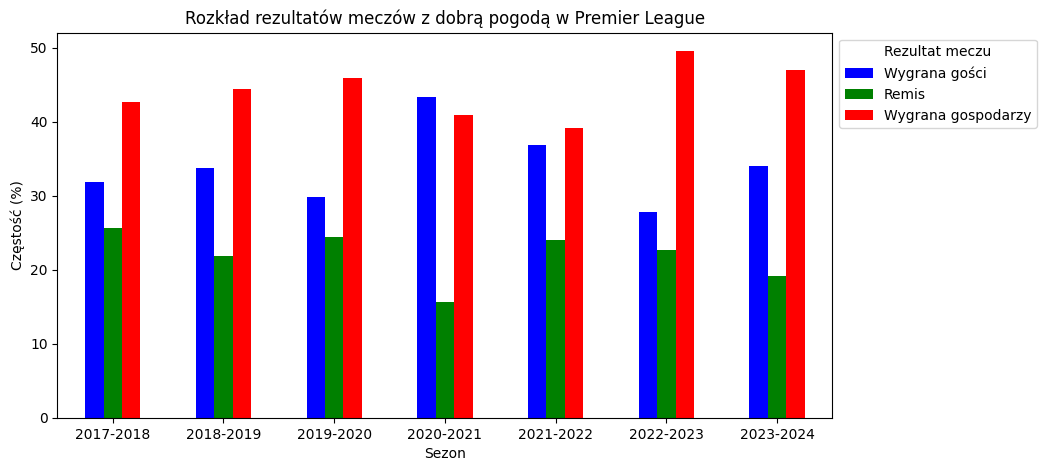

            away win       draw   home win
season                                    
2017-2018  31.782946  25.581395  42.635659
2018-2019  33.802817  21.830986  44.366197
2019-2020  29.761905  24.404762  45.833333
2020-2021  43.373494  15.662651  40.963855
2021-2022  36.842105  23.976608  39.181287
2022-2023  27.777778  22.685185  49.537037
2023-2024  33.950617  19.135802  46.913580
average    33.898809  21.896770  44.204421


In [187]:
plot_match_outcomes(foot_df[good_weather_ids], 'Rozkład rezultatów meczów z dobrą pogodą w Premier League')

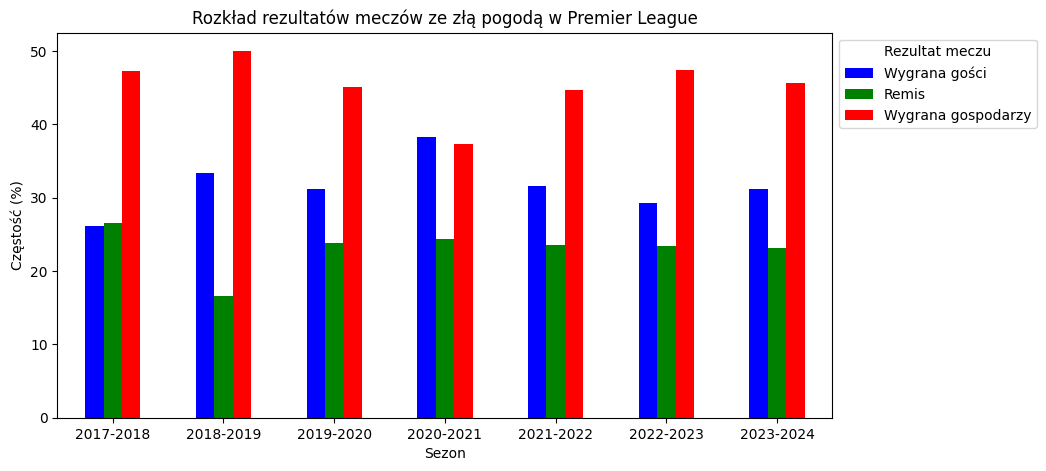

            away win       draw   home win
season                                    
2017-2018  26.141079  26.556017  47.302905
2018-2019  33.333333  16.666667  50.000000
2019-2020  31.188119  23.762376  45.049505
2020-2021  38.327526  24.390244  37.282230
2021-2022  31.658291  23.618090  44.723618
2022-2023  29.220779  23.376623  47.402597
2023-2024  31.250000  23.076923  45.673077
average    31.588447  23.063849  45.347705


In [188]:
plot_match_outcomes(foot_df[~good_weather_ids], 'Rozkład rezultatów meczów ze złą pogodą w Premier League')

C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\3955825795.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_goals_num = df.groupby('season').apply(


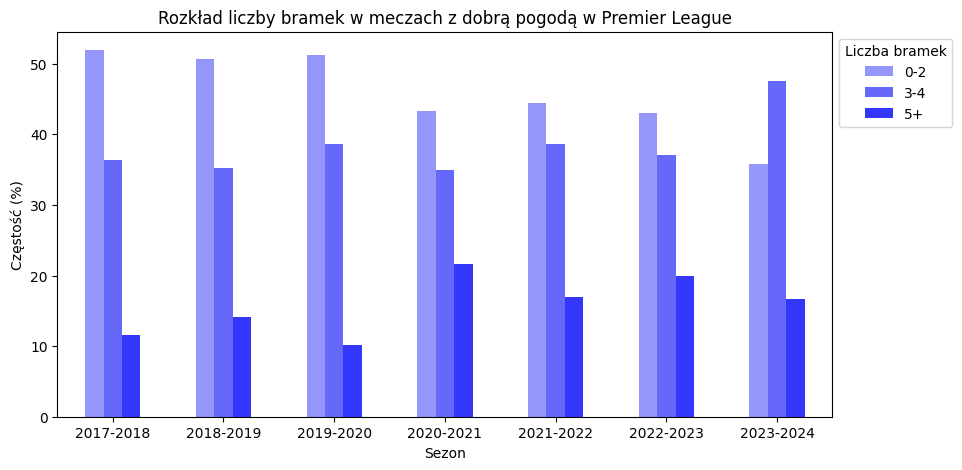

total_goals        0-2        3-4         5+
season                                      
2017-2018    51.937984  36.434109  11.627907
2018-2019    50.704225  35.211268  14.084507
2019-2020    51.190476  38.690476  10.119048
2020-2021    43.373494  34.939759  21.686747
2021-2022    44.444444  38.596491  16.959064
2022-2023    43.055556  37.037037  19.907407
2023-2024    35.802469  47.530864  16.666667
average      45.786950  38.348572  15.864478


In [189]:
plot_total_goals(foot_df[good_weather_ids], "Rozkład liczby bramek w meczach z dobrą pogodą w Premier League")

C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\3955825795.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_goals_num = df.groupby('season').apply(


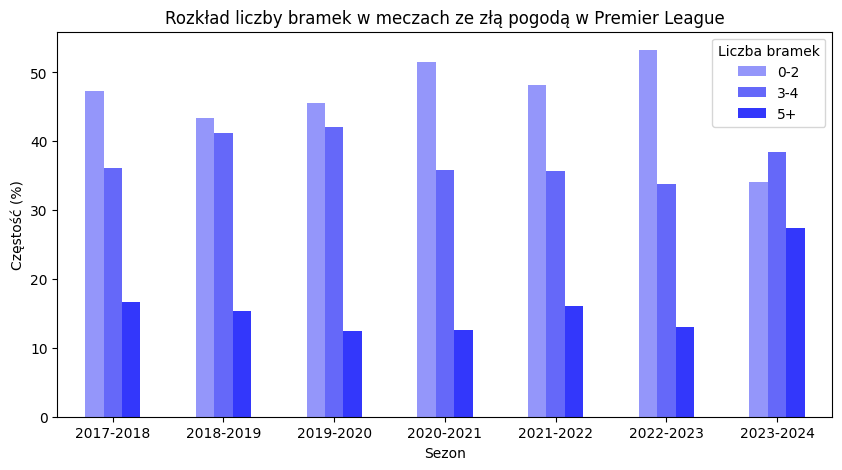

total_goals        0-2        3-4         5+
season                                      
2017-2018    47.302905  36.099585  16.597510
2018-2019    43.421053  41.228070  15.350877
2019-2020    45.544554  42.079208  12.376238
2020-2021    51.567944  35.888502  12.543554
2021-2022    48.241206  35.678392  16.080402
2022-2023    53.246753  33.766234  12.987013
2023-2024    34.134615  38.461538  27.403846
average      46.208433  37.600218  16.191349


In [190]:
plot_total_goals(foot_df[~good_weather_ids], "Rozkład liczby bramek w meczach ze złą pogodą w Premier League")

In [192]:
bad_weather_ids = ~good_weather_ids

In [193]:
def performance_of_team_by_weather(df, weather_ids, team, date):

    team_weather_df = df.copy()
    team_weather_df = team_weather_df[((df['home_team'] == team) | (df['away_team'] == team)) & (df['datetime'] < date) & (weather_ids)].sort_values(by='datetime').tail(20)
    
    points = []
    for _, match in team_weather_df.iterrows():
        if match['home_team'] == team:
            points.append(match['home_points'])
        elif match['away_team'] == team:
            points.append(match['away_points'])
    if not points:
        return 1.0
    
    return sum(points)/len(points)

In [194]:
foot_df['home_avg_points_good_weather'] = foot_df.apply(
    lambda row: performance_of_team_by_weather(foot_df, good_weather_ids, row['home_team'], row['datetime']), axis=1
)
foot_df['home_avg_points_bad_weather'] = foot_df.apply(
    lambda row: performance_of_team_by_weather(foot_df, bad_weather_ids, row['home_team'], row['datetime']), axis=1
)

foot_df['away_avg_points_good_weather'] = foot_df.apply(
    lambda row: performance_of_team_by_weather(foot_df, good_weather_ids, row['away_team'], row['datetime']), axis=1
)
foot_df['away_avg_points_bad_weather'] = foot_df.apply(
    lambda row: performance_of_team_by_weather(foot_df, bad_weather_ids, row['away_team'], row['datetime']), axis=1
)

In [195]:
foot_df.tail()

,season,datetime,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,League,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch width m,latit

In [196]:
foot_df[(foot_df["home_avg_points_good_weather"]- foot_df["home_avg_points_bad_weather"])>1].head(15)

,season,datetime,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,League,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch width m,latit

In [198]:
foot_df["good_to_bad_weather_win_ratio"] = (
    foot_df["home_avg_points_good_weather"] / (foot_df["home_avg_points_bad_weather"] + 1e-9)
)

foot_df["good_to_bad_weather_win_ratio"] = np.where(
    foot_df["good_to_bad_weather_win_ratio"] > 20, 1, foot_df["good_to_bad_weather_win_ratio"]
)

team_weather_condition_points = foot_df.groupby('home_team')["good_to_bad_weather_win_ratio"].mean()

print(team_weather_condition_points.mean())
print(team_weather_condition_points)

1.102275900021195
home_team
Arsenal                    1.083613
Aston Villa                1.169947
Bournemouth                1.231620
Brentford                  0.931875
Brighton & Hove Albion     1.230530
Burnley                    1.189583
Cardiff City               1.589113
Chelsea                    1.136708
Crystal Palace             1.404225
Everton                    1.243325
Fulham                     0.909210
Huddersfield Town          0.983716
Leeds United               1.275385
Leicester City             0.980019
Liverpool                  0.924348
Luton Town                 0.184476
Manchester City            0.937934
Manchester United          0.944359
Newcastle United           1.043095
Norwich City               0.811335
Nottingham Forest          1.231218
Sheffield United           1.012108
Southampton                1.030953
Stoke City                 1.483103
Swansea City               1.554655
Tottenham Hotspur          1.038307
Watford                    1.387297


In [282]:
features = ['home_last5_goals', 'away_last5_goals', 'home_last5_touches_att_3rd', 'away_last5_touches_att_3rd', 'home_last5_passes_completed', 'away_last5_passes_completed', 'home_last5_pass_xa', 'away_last5_pass_xa', 'home_avg_points_good_weather', 'home_avg_points_bad_weather', 'away_avg_points_bad_weather', 'away_avg_points_bad_weather']
earlier_seasons=['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']
last_seasons=['2023-2024']
X_train=foot_df[foot_df['season'].isin(earlier_seasons)][features]
y_train=(foot_df[foot_df['season'].isin(earlier_seasons)]['outcome']).astype(str)

X_test=foot_df[foot_df['season'].isin(last_seasons)][features]
y_test=(foot_df[foot_df['season'].isin(last_seasons)]['outcome']).astype(str)

rf = RandomForestClassifier(n_estimators=150, random_state=1)

rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)

y_pred = rf.predict(X_test)

y_pred_probabilities = rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

away_last5_passes_completed     0.100751
home_last5_passes_completed     0.099063
away_last5_touches_att_3rd      0.098697
home_last5_touches_att_3rd      0.096314
home_avg_points_good_weather    0.094585
home_avg_points_bad_weather     0.088045
home_last5_pass_xa              0.083448
away_last5_pass_xa              0.081238
away_avg_points_bad_weather     0.069035
away_avg_points_bad_weather     0.067275
away_last5_goals                0.061450
home_last5_goals                0.060100
dtype: float64
0.5486486486486486


In [283]:
home_win_probs=y_pred_probabilities[:, 2]
draw_probs=y_pred_probabilities[:, 1]
away_win_probs=y_pred_probabilities[:, 0]

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
C:\Users\Kuba\AppD

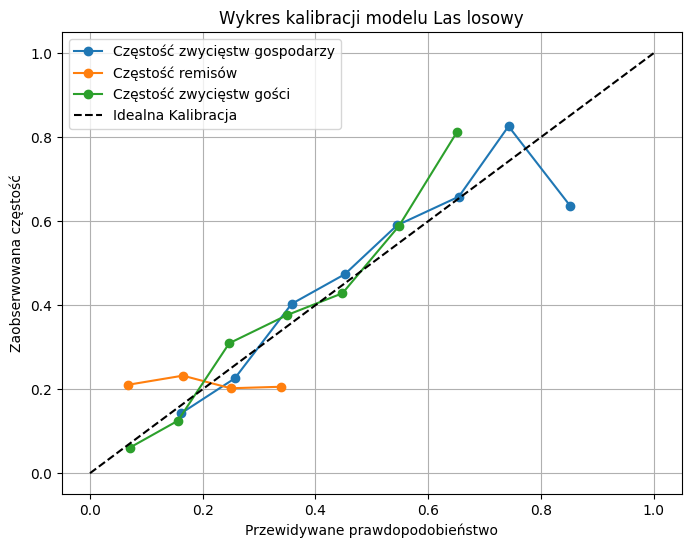

In [284]:
calibration_plot(pd.to_numeric(y_test), home_win_probs, away_win_probs, draw_probs, title="Wykres kalibracji modelu Las losowy")

In [285]:
search_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['log2', None],
}

rf = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator=rf, param_grid=search_params, cv=5, scoring='accuracy', verbose=3)
grid_search.fit(X_train, y_train)

print(f"Najlepsze parametry: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END max_depth=None, max_features=log2, n_estimators=50;, score=0.491 total time=   0.3s
[CV 2/5] END max_depth=None, max_features=log2, n_estimators=50;, score=0.516 total time=   0.3s
[CV 3/5] END max_depth=None, max_features=log2, n_estimators=50;, score=0.486 total time=   0.3s
[CV 4/5] END max_depth=None, max_features=log2, n_estimators=50;, score=0.518 total time=   0.3s
[CV 5/5] END max_depth=None, max_features=log2, n_estimators=50;, score=0.511 total time=   0.3s
[CV 1/5] END max_depth=None, max_features=log2, n_estimators=100;, score=0.523 total time=   0.6s
[CV 2/5] END max_depth=None, max_features=log2, n_estimators=100;, score=0.520 total time=   0.8s
[CV 3/5] END max_depth=None, max_features=log2, n_estimators=100;, score=0.489 total time=   3.1s
[CV 4/5] END max_depth=None, max_features=log2, n_estimators=100;, score=0.518 total time=   3.3s
[CV 5/5] END max_depth=None, max_features=log2, n_estimators=

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
C:\Users\Kuba\AppData\Local\Temp\ipykernel_64356\1412645384.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
C:\Users\Kuba\AppD

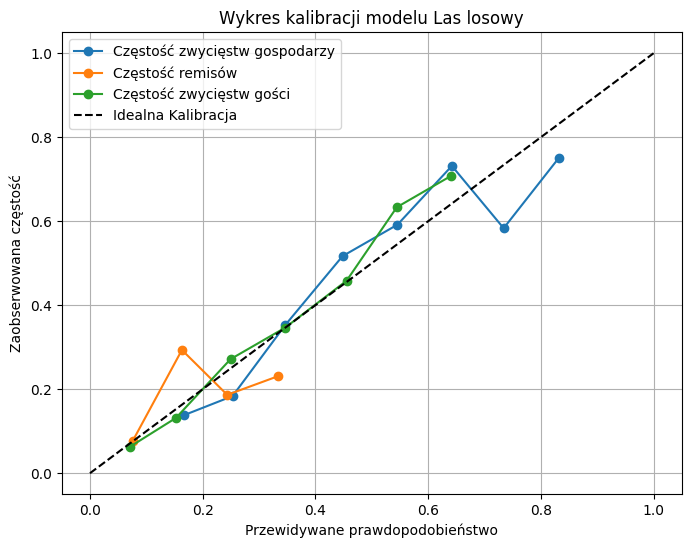

In [287]:
y_pred_probabilities = best_rf.predict_proba(X_test)
home_win_probs=y_pred_probabilities[:, 2]
draw_probs=y_pred_probabilities[:, 1]
away_win_probs=y_pred_probabilities[:, 0]
calibration_plot(pd.to_numeric(y_test), home_win_probs, away_win_probs, draw_probs, title="Wykres kalibracji modelu Las losowy")